# This file includes the methods we used in our project

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from causalml.inference.meta import BaseXRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import itertools

import xgboost as xgb
import itertools

import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
fig_dpi      = 300
fig_typeface = 'Helvetica'
fig_family   = 'monospace'
fig_style    = 'normal'

import warnings
warnings.filterwarnings("ignore")

In [5]:
dataset = pd.read_csv("data.csv")

In [2]:
dataset.head(2)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88


## Distrubution Of Two groups

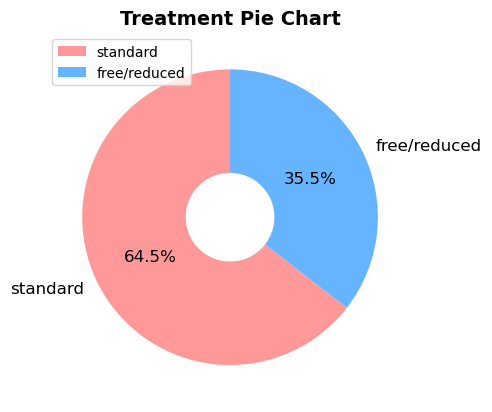

In [4]:
colors = ['#ff9999','#66b3ff']
Percentage = dataset["lunch"].value_counts()
Percentage.plot(kind="pie", colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.7), textprops={'fontsize': 12})
plt.ylabel(" ", fontsize=10)
plt.title("Treatment Pie Chart", fontsize=14, fontweight="bold")
plt.legend(labels = Percentage.index, loc="best", fontsize=10)
plt.show()

## Data Pre processing And define Bootstrap from HW2

In [6]:
dataset["Performance"] = dataset["math score"] + dataset["reading score"] + dataset["writing score"]
dataset = dataset.drop(columns=['math score', 'reading score', 'writing score'])
p = []
for i in dataset["Performance"]:
    if i >= np.median(dataset["Performance"]):
        p.append(1)
    else:
        p.append(0)
dataset["Performance"] = p
dataset[:2]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,Performance
0,female,group B,bachelor's degree,standard,none,1
1,female,group C,some college,standard,completed,1


In [7]:
confounders = dataset.copy()
confounders = confounders.drop("Performance", axis = 1)

for col in confounders.columns:
    confounders[col] = confounders[col].astype('category').cat.codes
A = 'lunch'
Y = 'Performance'
data = confounders.copy()
data['lunch'] = data['lunch'].map({0: 1, 1: 0})
data["Performance"] = dataset["Performance"]
data.head(2)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,Performance
0,0,1,1,0,1,1
1,0,2,4,0,0,1


In [7]:
def bootstrap(df, function, n=1000, ci=95, **kwargs):
    """
    From HW2
    """
    np.random.seed(396)  # Keep this random seed call for reproducibility
    resample = []
    for idx in range(n):
        sample = df.sample(frac=1.0, replace=True)
        afterFunc = function(sample, **kwargs)
        resample.append(afterFunc)
    resample = np.array(resample)
    pl = np.percentile(resample, (100 - ci) / 2, axis=0)
    pu = np.percentile(resample, 100 - (100 - ci) / 2, axis=0)
    return np.array([pl, pu])

# Naive ATE

## ATE value

In [8]:
ATE = {}
CG = data[data['lunch'] == 0]
TG = data[data['lunch'] == 1]
ATE = TG["Performance"].mean() - CG["Performance"].mean()

print(ATE)

-0.2245004913200131


## Uncertainty

In [9]:
np.random.seed(396)
resample = []
ci = 95
n = 1000
for idx in range(n):
    sample = data.sample(frac=1.0, replace=True)
    CG = sample[sample['lunch'] == 0]
    TG = sample[sample['lunch'] == 1]
    ATE = np.mean(TG["Performance"]) - np.mean(CG["Performance"])
    resample.append(ATE)
resample = np.array(resample)
pl = np.percentile(resample, (100 - ci) / 2, axis=0)
pu = np.percentile(resample, 100 - (100 - ci) / 2, axis=0)
print("[%.2f, %.2f]"%(pl, pu))

[-0.29, -0.16]


## Do calculus Backdoor

In [36]:
def BDAdj(confounders, data):
    '''
    This mothod is to use Backdoor adjustment to estimate the ATE.
    Args:
    confounders: the data without outcome variable but includes the treatment variable
    data: The dataset
    return: 
    bd_ATE: average treatment effect with backdoor adjustment estimation.
    '''
    bd_confounders = confounders.drop("lunch", axis=1).columns
    combo = [getVal(confounders, variable) for variable in bd_confounders]
    size = len(confounders)
    probs = calProb(confounders, data, size, combo)
    bd_ATE = calOut(probs)
    
    return bd_ATE

def bootstrap(data, function, n = 1000, ci = 95):
    np.random.seed(396)
    resample = []
    for idx in range(n):
        sample = data.sample(frac=1.0, replace=True)
        cf = (sample.copy()).drop("Performance", axis = 1)
        afterFunc = function(cf, sample)
        resample.append(afterFunc)
    resample = np.array(resample)
    pl = np.percentile(resample, (100 - ci) / 2, axis=0)
    pu = np.percentile(resample, 100 - (100 - ci) / 2, axis=0)
    return np.array([pl, pu])

def getVal(confounders, variable):
    return list(confounders[variable].unique())


def calProb(confounders, data, size, combo):
    probs = {}
    for c in itertools.product(*combo):
        sub_combo = filter_data(data, confounders, c)
        probs[c] = {}
        probs[c]['c'] = len(sub_combo) / size
        try:
            TG = sub_combo[sub_combo["lunch"] == 1]
            CG = sub_combo[sub_combo["lunch"] == 0]
            pT = len(TG) / len(sub_combo)
            pC = len(CG) / len(sub_combo)
            probs[c]['T_given_c'] = [pC, pT]
            probs[c]['Y_given_Tc'] = cal_YT_C(TG, CG)
        except:
            continue
    return probs

def filter_data(data, confounders, values):
    filters = []
    for variable, value in zip(confounders.columns, values):
        filters.append(data[variable] == value)
    sub_combo = data[np.logical_and.reduce(filters)]
    return sub_combo

def cal_YT_C(TG, CG):
    yT = TG[TG["Performance"] == 1]
    yC = CG[CG["Performance"] == 1]
    yT_c_values = [1 - len(yT) / len(TG), len(yT) / len(TG)] if len(TG) != 0 else [0, 0]
    yC_c_values = [1 - len(yC) / len(CG), len(yC) / len(CG)] if len(CG) != 0 else [0, 0]
    return {0: yC_c_values, 1: yT_c_values}

def calOut(probs):
    TG_outcome = 0
    CG_outcome = 0
    for c in probs.keys():
        if probs[c]['c'] != 0:
            TG_outcome += (1 * probs[c]['Y_given_Tc'][1][1]) * probs[c]['c']
            CG_outcome += (1 * probs[c]['Y_given_Tc'][0][1]) * probs[c]['c']
    bd_ATE = TG_outcome - CG_outcome
    return bd_ATE

##  IPW

In [38]:
def IPW(confounders, data, model = LogisticRegression(C = 1, penalty="l2")):
    '''
    This mothod is to use IPW to estimate the ATE.
    Args:
    confounders: the data without outcome variable but includes the treatment variable
    data: The dataset
    model: the model for the inverse propensity score
    
    return: 
    IPW: average treatment effect with IPW estimation
    '''
    C = confounders.drop(["lunch"], axis = 1)
    performance = data["Performance"]
    TG = data[data["lunch"] == 1]; C_TG = TG.drop(["lunch", "Performance"], axis = 1)
    CG = data[data["lunch"] == 0]; C_CG = CG.drop(["lunch", "Performance"], axis = 1)
    y_TG = TG["Performance"]
    y_CG = CG["Performance"]
    model = model
    model.fit(C, confounders["lunch"])
    T = model.predict_proba(C_TG)[:,1]
    C = model.predict_proba(C_CG)[:,1]
    n_cf = len(C)
    ETG = T[T!=0]; y_TG = y_TG[T!=0]
    ECG = C[C!=1]; y_CG = y_CG[C!=1]
    IPW = np.round( np.sum(y_TG / ETG) / n_cf -
                   np.sum(y_CG / (1 - ECG)) / n_cf, 2)
    return IPW

## Results of Do-calculus

In [40]:
do_cal_estimate = BDAdj(confounders, data)
do_cal_estimate
CI = bootstrap(data, BDAdj, n = 10)

In [42]:
do_cal_estimate, CI

(-0.25100000000000017, array([-0.28185, -0.20385]))

In [44]:
logistic_model = LogisticRegression(C = 1, penalty="l2")
confounders = data.drop(["Performance"], axis = 1)
ipw = IPW(confounders, data)
CI = bootstrap(data, IPW, n = 10)

In [45]:
ipw, CI

(-0.35, array([-0.37775, -0.2445 ]))

## Results of IPW

First we are trying to find out the the best hyperparameters

In [174]:
data.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'Performance'],
      dtype='object')

In [296]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["lunch"])
y = data['lunch']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=396)

rf_model = RandomForestClassifier(random_state=96, 
                                  n_estimators=100, 
                                  max_depth = 5, 
                                  min_samples_split = 6, 
                                  min_samples_leaf = 6)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
sum(y_pred == y_test)/len(y_pred)

0.655

In [260]:
logistic_model = LogisticRegression(C = 1, penalty="l2")
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)
sum(y_pred == y_test)/len(y_pred)

0.655

In [265]:
xgb_model = xgb.XGBClassifier(random_state=396, n_estimators = 70)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
sum(y_pred == y_test)/len(y_pred)

0.655

Then we use the best hyperparamters to get the ATE results

In [34]:
lr = LogisticRegression(C = 1, penalty="l2")
confounders= data.drop("Performance",axis = 1)
ipw = IPW(confounders, data, lr)
CI = bootstrap(data, IPW, n = 10)

In [35]:
ipw, CI

(-0.35, array([-0.37775, -0.2445 ]))

In [278]:
np.random.seed(396)
resample = []
ci = 95
n = 100
for idx in range(n):
    sample = data.sample(frac=1.0, replace=True)
    cf = (sample.copy()).drop("Performance", axis = 1)
    ATE = IPW(cf, sample)
    resample.append(ATE)
resample = np.array(resample)
pl = np.percentile(resample, (100 - ci) / 2, axis=0)
pu = np.percentile(resample, 100 - (100 - ci) / 2, axis=0)

print("[%.2f, %.2f]"%(pl, pu))

[-0.49, -0.29]


In [162]:
sample.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'Performance'],
      dtype='object')

In [284]:
confounders= data.drop("Performance",axis = 1)
ipw = IPW(confounders, data, model)
ipw

-0.35

In [282]:
np.random.seed(396)
resample = []
ci = 95
n = 1000
for idx in range(n):
    sample = data.sample(frac=1.0, replace=True)
    cf = (sample.copy()).drop("Performance", axis = 1)
    ATE = IPW(cf, sample)

    resample.append(ATE)
resample = np.array(resample)
pl = np.percentile(resample, (100 - ci) / 2, axis=0)
pu = np.percentile(resample, 100 - (100 - ci) / 2, axis=0)

In [283]:
print("[%.2f, %.2f]"%(pl, pu))

[-0.44, -0.26]


## Double Meching Learning

- Bach, P., Chernozhukov, V., Kurz, M. S., and Spindler, M. (2022), DoubleML - An Object-Oriented Implementation of Double Machine Learning in Python, Journal of Machine Learning Research, 23(53): 1-6, https://www.jmlr.org/papers/v23/21-0862.html.


In [320]:
# Creat double mL data
from doubleml import DoubleMLData
dml_data = DoubleMLData(data,
                              y_col='Performance',
                              d_cols='lunch',
                              x_cols=['gender', 'race/ethnicity', 'parental level of education','test preparation course'])
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: Performance
Treatment variable(s): ['lunch']
Covariates: ['gender', 'race/ethnicity', 'parental level of education', 'test preparation course']
Instrument variable(s): None
No. Observations: 1000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 6 entries, gender to Performance
dtypes: int64(2), int8(4)
memory usage: 19.7 KB



In [306]:
X = data[['gender', 'race/ethnicity', 'parental level of education','test preparation course']]
y = data["Performance"]
d = data["lunch"]

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [321]:
dml_data_ploy = DoubleMLData.from_arrays(X_poly, y, d)
print(dml_data_ploy)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14']
Instrument variable(s): None
No. Observations: 1000

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 16 entries, X1 to d
dtypes: float64(16)
memory usage: 125.1 KB



In [333]:
from sklearn.base import clone
#learner = RandomForestRegressor(max_depth = 15, random_state=396, n_estimators=100)
learner = RandomForestRegressor(max_depth = 15, random_state=396, n_estimators=100)
ml_l_ploy = clone(learner)
ml_m_ploy = clone(learner)
from doubleml import DoubleMLPLR
np.random.seed(396)
obj_dml_plr_ploy = DoubleMLPLR(dml_data_ploy, ml_l_ploy, ml_m_ploy)
obj_dml_plr_ploy.fit()
print(obj_dml_plr_ploy)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14']
Instrument variable(s): None
No. Observations: 1000

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_depth=15, random_state=396)
Learner ml_m: RandomForestRegressor(max_depth=15, random_state=396)
Out-of-sample Performance:
Learner ml_l RMSE: [[0.50684079]]
Learner ml_m RMSE: [[0.52099487]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
       coef   std err         t         P>|t|    2.5 %    97.5 %
d -0.233442  0.029811 -7.830841  4.846

In [323]:
print(obj_dml_plr_sim.all_coef)

[[-0.23344211]]


## Meta Learner_models

- Künzel, Sören R., Jasjeet S. Sekhon, Peter J. Bickel, and Bin Yu. "Metalearners for Estimating Heterogeneous Treatment Effects Using Machine Learning." February 15, 2019. https://doi.org/10.1073/pnas.1804597116.

In [11]:
def XLearner(data, model1, model2):
    from sklearn.linear_model import LinearRegression
    '''
    This mothod is to use XLearner to estimate the ATE.
    Args:
    data: The dataset
    model1: the model for the treatment group
    model2: the model for the control group
    
    return: 
    ATE: average treatment effect
    CI: confidence interval for ATE
    '''
    treatmentLearner = model1
    controlLearner = model2
    prop_model = LinearRegression()

    XLearner = BaseXRegressor(treatmentLearner, controlLearner, prop_model)
    confounders = data.drop(["Performance", "lunch"], axis = 1)
    treatment = data["lunch"]
    performance = data["Performance"]
    XLearner.fit(X=confounders, treatment=treatment, y=performance)
    ATE_array = XLearner.estimate_ate(X=confounders, treatment=treatment, y=performance)
    ATE = ATE_array[0][0]
    CI = [ATE_array[1][0], ATE_array[2][0]]
    return ATE, CI
def SLearner(data, model):
    '''
    This method is to use SLearner to estimate the ATE.
    Args:
    data: The dataset
    model: prediction model
    
    return:
    ATE: average treatment effect
    CI: confidence interval for ATE
    '''
    confounders = data.drop(["Performance", "lunch"], axis = 1)
    treatment = data["lunch"]
    performance = data["Performance"]
    
    data_C_Real = np.hstack([confounders, np.array(treatment).reshape(-1, 1)])
    model = model
    model.fit(data_C_Real, performance)

    data_C_T = np.hstack([confounders, np.ones((confounders.shape[0], 1))])
    data_C_C = np.hstack([confounders, np.zeros((confounders.shape[0], 1))])   # assume all are control
    Y_hat_T = model.predict(data_C_T)
    Y_hat_C = model.predict(data_C_C)
    
    SLearnerPrediction = Y_hat_T - Y_hat_C
    
    ATE = np.mean(SLearnerPrediction)
    CI = [np.percentile(SLearnerPrediction, (100 - 95) / 2, axis=0), 
          np.percentile(SLearnerPrediction, 100 - (100 - 95) / 2, axis=0)]
    return ATE, CI

def TLearner(data, model1, model2):
    '''
    This method is to use TLearner to estimate the ATE.
    Args:
    data: The dataset
    model1: prediction model for TG
    model2: prediction model for CG
    
    return:
    ATE: average treatment effect
    CI: confidence interval for ATE
    '''
    confounders = data.drop(["Performance", "lunch"], axis = 1)
    treatment = data["lunch"]
    performance = data["Performance"]

    ConfoundersOfTG = confounders[treatment == 1]
    YOfTG = performance[treatment == 1]
    ConfoundersOfCG = confounders[treatment == 0]
    YOfCG = performance[treatment == 0]


    model_TG = model1
    model_TG.fit(ConfoundersOfTG, YOfTG)

    model_CG = model2
    model_CG.fit(ConfoundersOfCG, YOfCG)

    Y_hat_T = model_TG.predict(confounders)
    Y_hat_C = model_CG.predict(confounders)

    TLearnerPrediction = Y_hat_T - Y_hat_C
    ATE = np.mean(TLearnerPrediction)
    CI = [np.percentile(TLearnerPrediction, (100 - 95) / 2, axis=0), 
          np.percentile(TLearnerPrediction, 100 - (100 - 95) / 2, axis=0)]
    return ATE, CI

In [8]:
ATE_T, CI_T = TLearner(data, XGBRegressor(), XGBRegressor())
ATE_T, CI_T

(-0.23829892, [-0.7874327301979065, 0.41039276123046875])

In [9]:
ATE_S, CI_S = SLearner(data, XGBRegressor())
ATE_S, CI_S

(-0.23485108, [-0.7707615494728088, 0.42324262857437134])

In [13]:
from sklearn.ensemble import RandomForestRegressor
ATE_X, CI_X = XLearner(data, RandomForestRegressor(), RandomForestRegressor())
ATE_X, CI_X

(-0.22086472860979967, [-0.28005016622384626, -0.16167929099575304])